In [ ]:
"""
Use movie_data_general_cleaned to build a Linear Regression model for general movies.

Final feature engineering: include all categorical features
Regularization: Ridge slightly better than LASSO

functions used:
get_Xy(df) from model.py
get_score(X_train,X_val,y_train,y_val) from model.py
categorical_multilabel(X_train,X_val,X_test,cat_variable) from model.py
categorical_singlelabel(X_train,X_val,X_test,cat_variable) from model.py


Result:

Validation set R^2 ~ 0.55
Test set R^2 ~ 0.59

Test set using movie adpataions data R^2 ~ -0.4

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

import patsy
import scipy.stats as stats

import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_2/py')
import importlib
from model import *

## 1. Prepare data

In [2]:
# Load the cleaned complete data
all_df = pd.read_pickle('../data/movie_data_general_cleaned')

# Separate features and target
con_feature = ['budget','runtime','release_year']
cat_feature = ['MPAA','genre','distributor','language','country','keywords']
target_candidate = ['opening_weekend_usa','gross_usa','gross_world','rating','vote']

# Load top 100 actor list
actor_list = pd.read_pickle('../dump/actor_top100_list')

## 2. All categorical variables

In [3]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [5]:
scaler = StandardScaler()
poly = PolynomialFeatures()

# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]


# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


# Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]


# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


# Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [15]:
X_train.shape, X_val.shape

((3067, 108), (1023, 108))

In [16]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.5083815648124674

In [17]:
list(zip(poly.get_feature_names(X_val_con.columns), lr.coef_))

[('1', 1.4988057873540044),
 ('budget', 3.39615673347718),
 ('runtime', -2.180434346722048),
 ('release_year', 0.27334310587455146),
 ('budget^2', 0.6186106933222022),
 ('budget runtime', -0.8022079494539242),
 ('budget release_year', -0.8968929845715277),
 ('runtime^2', 0.03648073634178228),
 ('runtime release_year', 7.232040471309745),
 ('release_year^2', -4.427964835335576)]


Train R^2 score was: 0.5083815648124674
Validation R^2 score was: 0.5033711471693088
RMSE: 11.24 



(<Figure size 432x288 with 1 Axes>,
 LinearRegression(),
 array([19.83008903,  1.93953583,  6.18371707, ...,  9.27171952,
        23.56286177, 16.2293753 ]))

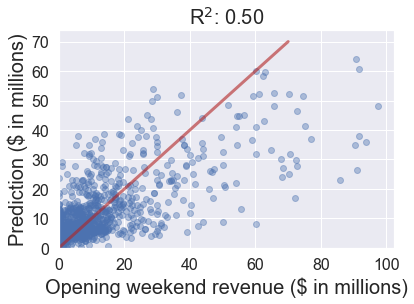

In [18]:
get_score(X_train, X_val, y_train, y_val)

In [19]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.45180110769788373
[0.47508859 0.47124858 0.45220939 0.45277775 0.40768122]


## 3. Regularization

### * Ridge

In [671]:
## Fit a Ridge model on the standardized data

# ridge_model = Ridge(alpha = 0.001)
# ridge_model.fit(X_train,y_train)
# list(zip(X_train.columns, ridge_model.coef_))

In [672]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)
print('The best value of alpha is:', ridge_model.alpha_)

The best value of alpha is: 19.199206655932848


In [822]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 19.1992)
ridge_model.fit(X_train,y_train)
list(zip(X_train_con_scaled_df.columns, ridge_model.coef_))

[('1', -0.9006304654396056),
 ('budget', 0.4540576562333814),
 ('runtime', -1.4498517710363454),
 ('release_year', -0.3144401302558543),
 ('budget^2', 1.1640945933944702),
 ('budget runtime', -1.7635365866172787),
 ('budget release_year', 2.4198130323964473),
 ('runtime^2', -0.5371311958961529),
 ('runtime release_year', -0.24232404943451424),
 ('release_year^2', 1.4681540795777903)]

In [823]:
# Evaluation using validation set
y_pred = ridge_model.predict(X_val)
r2_score(y_val, y_pred)

0.546117967041067

In [842]:
# X_test score
y_pred = ridge_model.predict(X_test)
r2_score(y_test, y_pred)

0.589207549751184

(0.0, 102.24400725000001)

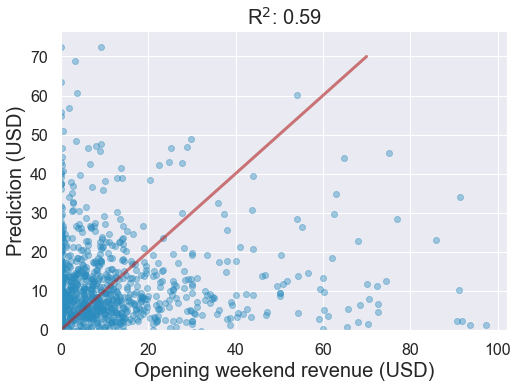

In [843]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_test, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

x=np.linspace(0,0.7e2,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6);
plt.ylim(0,)
plt.xlim(0,)

In [844]:
fig.savefig('../plot/ridge_prediction_test.pdf', bbox_inches='tight', transparent = True)

(0.0, 102.24400725000001)

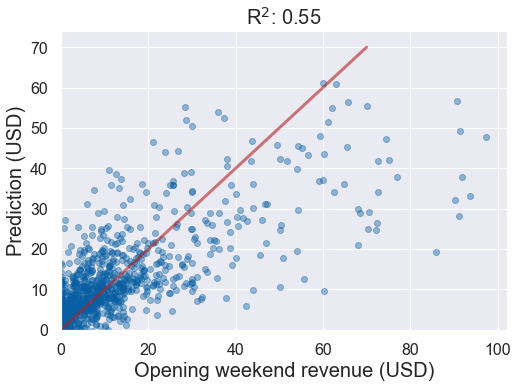

In [685]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_val, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)

In [687]:
fig.savefig('../plot/ridge_prediction.pdf', bbox_inches='tight', transparent = True)

In [693]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

10.740548723211116

### * LASSO

In [688]:
# lasso_model = Lasso(alpha = 0.001)
# lasso_model.fit(X_train,y_train)
# list(zip(X_train_con_scaled_df.columns, lasso_model.coef_))

In [695]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha


alphavec = 10**np.linspace(-5,5,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)
print('The best value of alpha is:', lasso_model.alpha_)

The best value of alpha is: 0.021544346900318846


In [697]:
lasso_model = Lasso(alpha = 0.0215)
lasso_model.fit(X_train,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('GeorgetownProductionsInc.', 0.0),
 ('Ukrainian', -0.0),
 ('Mandarin', -0.0),
 ('Vietnamese', -0.0),
 ('Arabic', -0.0),
 ('Swahili', -0.0),
 ('BlueSkyStudios', -0.0),
 ('Tagalog', -0.0),
 ('ScottishGaelic', 0.0),
 ('ReelFXCreativeStudios', -0.0),
 ('SaudiArabia', -0.0),
 ('G', 0.0),
 ('BlackBearPictures', -0.0),
 ('IMGlobal', -0.0),
 ('PixarAnimationStudios', 0.0),
 ('ColumbiaPictures', 1.0052196377455793),
 ('LegendaryEntertainment', -0.0),
 ('EndgameEntertainment', -0.0),
 ('Comedy', -0.1841757551183052),
 ('Japan', 1.1022128538387324),
 ('Austria', 0.0),
 ('Unrated', -0.0),
 ('CinergiPicturesEntertainment', -0.0),
 ('Serbian', -0.0),
 ('QuadProductions', -0.0),
 ('Czech', 4.906781827682248),
 ('Norwegian', -2.0123131778570036),
 ('MajorStudioPartners', -0.0),
 ('Romanian', -0.0),
 ('Hawaiian', 0.0),
 ('Romania', 0.0),
 ('Tibetan', -0.0),
 ('FirstLookInternational', 0.0),
 ('TapestryFilms', -0.0),
 ('DreamWorksAnimation', 5.482976944401251),
 ('BrazilianSignLanguage', 0.0),
 ('Hebr

In [708]:
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso_model.coef_)),columns=['Feature','Coefficient'])
lassp_top = lasso_coef.sort_values(by=['Coefficient'],ascending=False).head(20)

In [718]:
lassp_top.Feature.tolist()

['budget',
 'Lucasfilm',
 'DreamWorksAnimation',
 'Czech',
 'NewLineCinema',
 'UniversalPictures',
 'ScreenGems',
 'TwentiethCenturyFox',
 'ParamountPictures',
 'Horror',
 'release_year',
 'Animation',
 'Italian',
 'WaltDisneyPictures',
 'runtime',
 'budget release_year',
 'WarnerBros.',
 'Japan',
 'Lionsgate',
 'ColumbiaPictures']

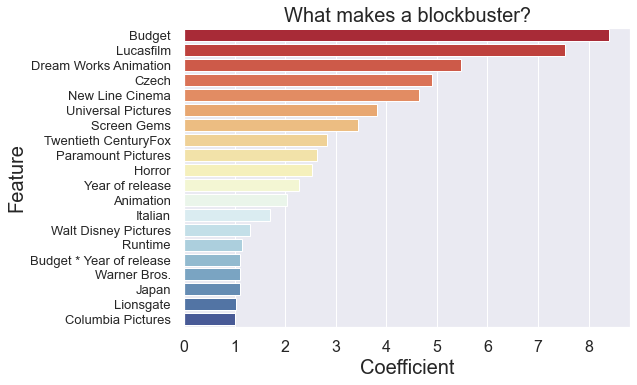

In [733]:
# Generate coef plots for the 10 features

p = sns.color_palette("RdYlBu",20)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.set_palette(p)
sns.barplot(y="Feature", x= 'Coefficient', data = lassp_top,orient='h')
ax.set_title('What makes a blockbuster?',fontsize=20)
ax.set_ylabel('Feature',fontsize=20)
ax.set_xlabel('Coefficient',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=13)
# ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
ax.set_yticklabels(['Budget',
 'Lucasfilm',
 'Dream Works Animation',
 'Czech',
 'New Line Cinema',
 'Universal Pictures',
 'Screen Gems',
 'Twentieth CenturyFox',
 'Paramount Pictures',
 'Horror',
 'Year of release',
 'Animation',
 'Italian',
 'Walt Disney Pictures',
 'Runtime',
 'Budget * Year of release',
 'Warner Bros.',
 'Japan',
 'Lionsgate',
 'Columbia Pictures'])

fig.savefig('../plot/lasso_coef.pdf', bbox_inches='tight', transparent=True)

In [699]:
# Evaluation using validation set
val_pred = lasso_model.predict(X_val)
r2_score(y_val, val_pred)

0.5434235287972282

In [ ]:
# Compared to Ridge: 0.546117967041067
# Ridge is slightly better

(0.0, 102.24400725000001)

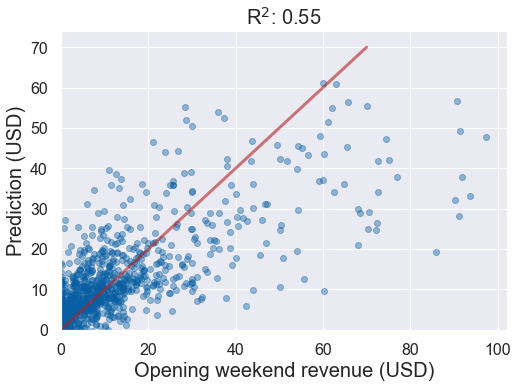

In [700]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_val, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)

### Find outliers

In [808]:
lc_df = all_df[['movie_title'] + ['opening_weekend_usa'] + con_feature + 
               ['genre','release_year','rating']].copy().dropna()

In [810]:
lc_df.drop_duplicates(subset=['movie_title','release_year'],keep='first',inplace=True)

In [811]:
X = lc_df[con_feature + ['rating']]
y = lc_df['opening_weekend_usa']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=58)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)
lc_df['res'] = lr.predict(lc_df[con_feature + ['rating']])-lc_df['opening_weekend_usa']

In [812]:
res1 = lc_df[['movie_title','genre','res']].sort_values(['res']).dropna().head(100)
res1.head(15)

,movie_title,genre,res
46,Joker,"[Crime, Drama, Thriller]",-76.432654
234,Fifty Shades of Grey,"[Drama, Romance, Thriller]",-74.037323
1600,Halloween,"[Crime, Horror, Thriller]",-69.834310
457,It Chapter Two,"[Drama, Fantasy, Horror]",-68.496035
329,Us,"[Horror, Mystery, Thriller]",-62.068580
325,Harry Potter and the Chamber of Secrets,"[Adventure, Family, Fantasy]",-61.293593
1509,The Hangover Part II,[Comedy],-61.176890
166,Twilight,"[Drama, Fantasy, Romance]",-58.788479
2725,Despicable Me 2,"[Animation, Adventure, Comedy]",-58.753424
1958,Pitch Perfect 2,"[Comedy, Music]",-58.459170


In [826]:
res2 = lc_df[['movie_title','genre','res']].sort_values(['res']).tail(100)
res2.tail(20).sort_values(['res'],ascending=False)

,movie_title,genre,res
1502,The Protector,"[Action, Crime, Drama]",51.849885
409,Frozen,"[Animation, Adventure, Comedy]",44.472325
1443,John Carter,"[Action, Adventure, Sci-Fi]",39.555387
2390,47 Ronin,"[Action, Drama, Fantasy]",39.531068
280,The Revenant,"[Action, Adventure, Drama]",38.792060
3,Tenet,"[Action, Sci-Fi, Thriller]",38.237715
2963,Brother Bear,"[Animation, Adventure, Comedy]",37.601438
2826,Mars Needs Moms,"[Animation, Action, Adventure]",36.411824
2910,The 13th Warrior,"[Action, Adventure, History]",34.992287
793,King Arthur: Legend of the Sword,"[Action, Adventure, Drama]",34.921252


### Use movie based on books as test set

In [33]:
# Load the cleaned complete data
adaptation_df = pd.read_pickle('../dump/complete_data_cleaned_test')

In [34]:
adaptation_df.rename(columns = {'actor':'star'},inplace=True)

In [35]:
adaptation_df.dropna(inplace=True)

In [36]:
X_test = adaptation_df[con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
y_test = adaptation_df['opening_weekend_usa']

In [37]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 19.1992)
ridge_model.fit(X_train,y_train)
list(zip(X_train_con_scaled_df.columns, ridge_model.coef_))

[('1', -1.4466001997593665),
 ('budget', -1.8884571149038998),
 ('runtime', -0.2931989297139589),
 ('release_year', 2.3463851501800588),
 ('budget^2', -0.5476670917119352),
 ('budget runtime', 3.8598497513080985),
 ('budget release_year', 1.0345405329436708),
 ('runtime^2', -1.4330070584761097),
 ('runtime release_year', 1.3626920517390735),
 ('release_year^2', 0.12838688952804528)]

In [38]:
y_pred = ridge_model.predict(X_val)
r2_score(y_val, y_pred)

0.5457035101167601

In [45]:

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only = False)


# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

# use movie adapations as test set
X_test = adaptation_df[con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
y_test = adaptation_df['opening_weekend_usa']


# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = poly.fit_transform(scaler.fit_transform(X_train_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns = poly_column,\
                                     index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = poly.transform(scaler.fit_transform(X_val_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns = poly_column,\
                                   index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]



# Test set
# Convert genre to dummies
X_test_genre = X_test['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_test_MPAA = pd.get_dummies(X_test['MPAA'])
X_test_language= X_test['language'].str.join(sep='*').str.get_dummies(sep='*')
X_test_country = X_test['country'].str.join(sep='*').str.get_dummies(sep='*')
X_test_distributor = pd.get_dummies(X_test['distributor'])

# Scaling continuous variables
X_test_con = X_test[con_feature]
X_test_con_scaled = poly.transform(scaler.fit_transform(X_test_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_test_con_scaled_df = pd.DataFrame(X_test_con_scaled, columns = poly_column,\
                                   index=X_test_con.index)

#Combine
X_test = pd.concat([X_test_genre,X_test_MPAA, X_test_language, X_test_country, X_test_distributor, \
                   X_test_con_scaled_df],axis=1)

# Find the common columns to keep
keep2 = list(set(X_test.columns).intersection(set(keep)))
X_train = X_train[keep2]
X_val = X_val[keep2]
X_test = X_test[keep2]




Train R^2 score was: 0.5731982482267731
Validation R^2 score was: 0.5351265134037417
RMSE: 10.87 



(<Figure size 432x288 with 1 Axes>,
 LinearRegression(),
 array([15.40820312, -6.38378906, 12.89941406, ...,  8.07617188,
        -7.27246094, 21.52636719]))

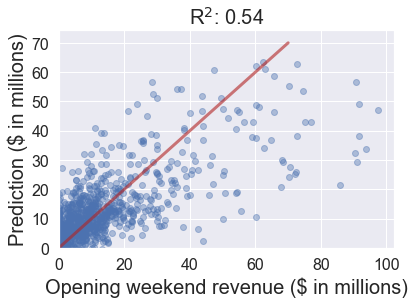

In [49]:
get_score(X_train, X_val, y_train, y_val)


Train R^2 score was: 0.5731982482267731
Validation R^2 score was: -0.3992789078118748
RMSE: 20985998.48 



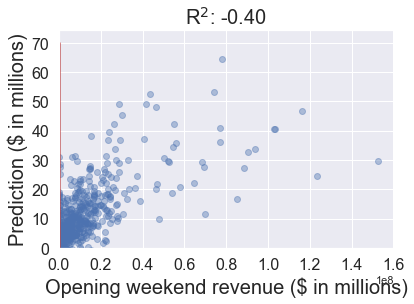

In [50]:
fig,lr,y_pred = get_score(X_train, X_test, y_train, y_test)

In [ ]:
### Using the movie adaptations data as test set results in negative R^2